In [8]:
import numpy as np
import graphinglib as gl
from collections import namedtuple
import astropy.units as u

from src.hdu.cubes.cube_co import CubeCO
from src.spectrums.spectrum_co import SpectrumCO
from src.spectrums.spectrum import Spectrum
from src.hdu.tesseract import Tesseract
from src.hdu.maps.grouped_maps import GroupedMaps
from src.hdu.maps.convenient_funcs import get_FWHM, get_speed
from src.coordinates.ds9_coords import DS9Coords

### Loop4N1 ```GOOD```
### Loop4N2 
### Loop4N4 
### Loop4p  

# Loop4N1

In [9]:
N1 = CubeCO.load("data/Loop4_co/N1/13co/Loop4N1_13co.fits")[500:800,:,:]
N1.header["COMMENT"] = "Loop4N1_FinalJS was sliced at channel 500; all values of mean must then be " \
                        + "added to 500 to account for this shift."

## Fitting

In [10]:
if __name__ == "__main__":
    spectrum_parameters = {
        "PEAK_PROMINENCE" : 0.2,
        "PEAK_MINIMUM_HEIGHT_SIGMAS" : 4,
        "PEAK_MINIMUM_DISTANCE" : 6,
        "PEAK_WIDTH" : 3,
        "NOISE_CHANNELS" : slice(0,150),
        "INITIAL_GUESSES_BINNING" : 2,
        "MAX_RESIDUE_SIGMAS" : 100,
        "STDDEV_DETECTION_THRESHOLD" : 0.1,
        "INITIAL_GUESSES_MAXIMUM_GAUSSIAN_STDDEV" : 10,
        "INITIAL_GUESSES_MINIMUM_GAUSSIAN_STDDEV" : 1,
    }

    N1.header["COMMENT"] = f"FITTING PARAMETERS "
    for key, value in spectrum_parameters.items():
        N1.header["COMMENT"] = f"{key} = {value}"

    chi2, fit_results = N1.fit(spectrum_parameters)
    chi2.save("data/Loop4_co/N1/13co/chi2.fits")
    fit_results.save("data/Loop4_co/N1/13co/tesseract.fits")

Number of processes used: 8


Fitting: 100%|██████████| 50/50 [00:01<00:00, 40.12fit/s]


File overwritten.
File overwritten.


## Verifications

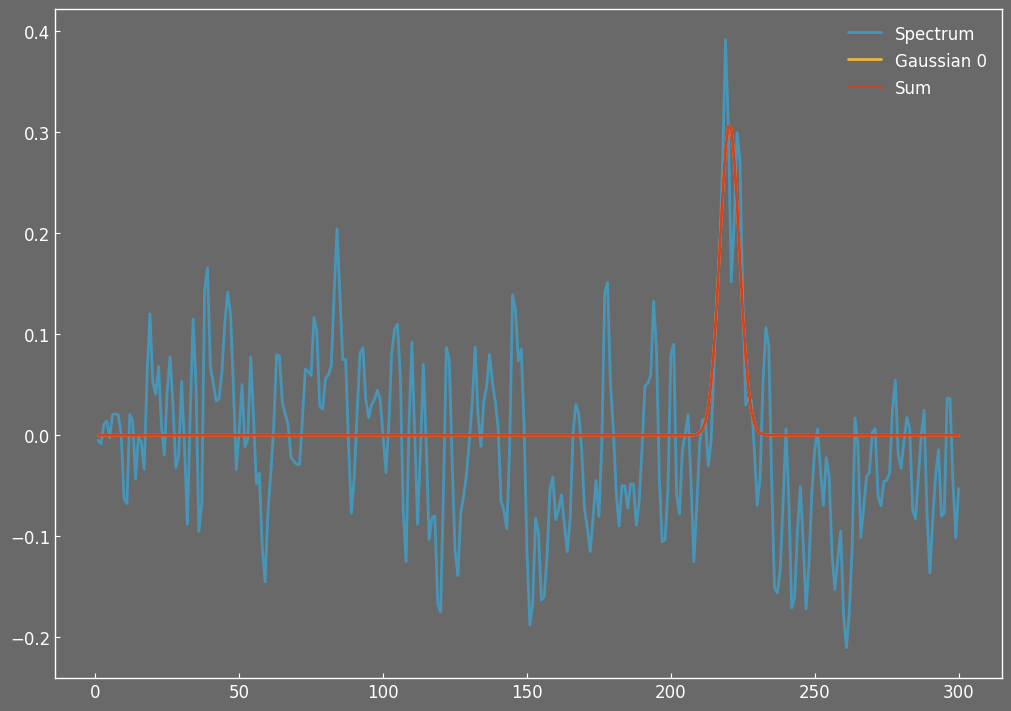

In [7]:
total_object_N1 = Tesseract.load(f"data/Loop4_co/N1/13co/tesseract.fits")
fig = gl.Figure(size=(10,7), figure_style="dim")
fig.add_elements(*total_object_N1.get_spectrum_plot(N1, DS9Coords(14, 33)))
fig.show()